In [2]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

TODO: 
* Load model
* Plot intensity distribution
* Evaluate a good threshold (Weakly Supervised Deep Learning for Segmentationof Remote Sensing Imagery)

Some help:
https://stackoverflow.com/questions/64617205/merging-each-instance-mask-back-to-the-original-image-python
https://stackoverflow.com/questions/61383095/create-mask-or-boundary-from-each-other-in-python3

In [3]:
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold
from src.utils.utils import split_custom_filename
from src.segmentation import cam
from src.classifier.agent import load_trainer
from src.segmentation.cam import CAMS
from src.segmentation import segmentation
import nibabel as nib


import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [4]:
# Load models
trainer, dataset, model = load_trainer('resnet50', checkpoint_path="/logs/tb/resnet50/version_0/checkpoints/checkpoint-v1.ckpt");
cam_extractor = cam.CAM(CAMS.SmoothGradCAMpp.value, model)

# Load example image
filename= '../data/SPM_categorised/AIH/CN/CN_ADNI_0443.nii'
class_label = split_custom_filename(filename,'/')[4]
image = image2axial(nib.load(filename).get_fdata())

Loading model from /home/stud1/f/fremar16/Master_thesis/logs/tb/resnet50/version_0/checkpoints/checkpoint-v1.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet50', 'args': {'num_channels': 1, 'num_classes': 3}}
"callbacks":           ['litprogressbar', 'modelcheckpoints', 'metriccallback']
"class_weights":       None
"hp_metrics":          ['loss/train', 'loss/val', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"kfold":               {'enable': False, 'folds': 10}
"loss":                CrossEntropyLoss
"loss_weight_balance": None
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0002, 'weight_decay': 1e-05, 'amsgrad': False}}
"roi_enabled":         False
"roi_hparams":         {'enable': False, 'output_shape': [40, 40, 40], 'boundary_boxes': []}
Dataset sizes - Training: 421 Validation: 47


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


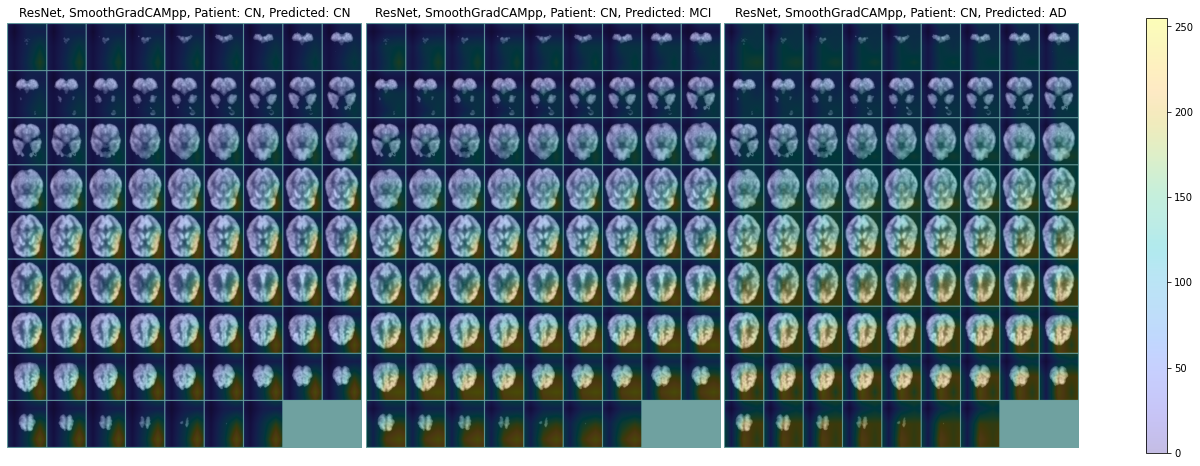

In [5]:
class_scores, class_idx = cam_extractor.evaluate(image)
grid_image, grid_mask = cam_extractor.grid_class(class_scores, [0,1,2], image,pad_value=0, max_num_slices=None)
masked_image = cam_extractor.preprocess(cam_extractor.activation_map(class_idx, class_scores))
cam_extractor.plot(class_scores, [0,1,2],image, max_num_slices=None, class_label=class_label);


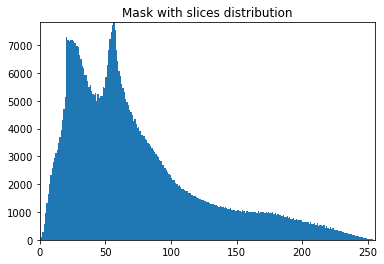

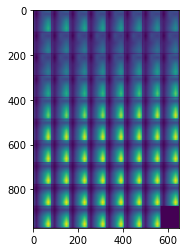

In [11]:
# Only check the distribution from each image! This looks a lot better!
sliced_masks = cam_extractor.preprocess(cam_extractor.activation_map(0, class_scores))

#segmentation.intensity_distribution(sliced_masks[30].flatten(),title="Mask with slices distribution")
segmentation.intensity_distribution(sliced_masks.flatten(),title="Mask with slices distribution")

plt.imshow(torchvision.utils.make_grid(torch.from_numpy(sliced_masks).unsqueeze(1), nrow=8)[0])

# Extract Segmentation and boundary boxes

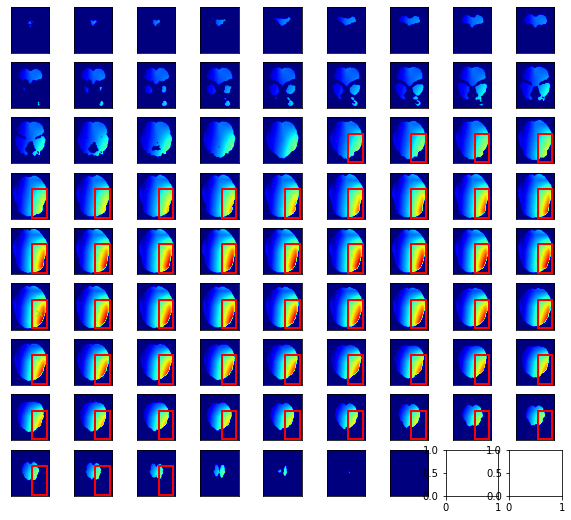

In [17]:
features = segmentation.sequential_processing(image, sliced_masks)

# RoIAlign

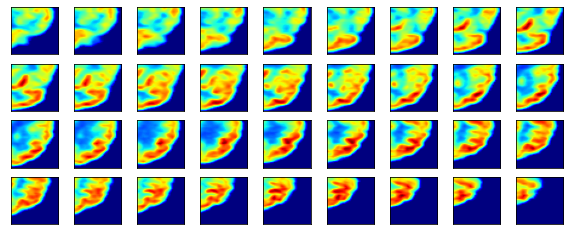

In [18]:
derp = segmentation.roi_align(image, segmentation.bounding_boxes(features), displayed=True)

## Extract all regions

In [14]:
from src.classifier.dataloader.dataset import AdniDataset
from src.utils import load
import src
from src.segmentation.segmentation import RoiTransform
import itertools
from skimage import measure
# Load a dataloader here!
files = load.load_files(src.BASEDIR + "/"+"data/SPM_categorised/AIH")
fileset = AdniDataset(files)

def feature_extraction(cam_extractor):
    for (i, (image, patient_class)), observe_class in itertools.product(enumerate(fileset),[0,1,2]):
        image_name = fileset.data[i].rsplit("/",1)[1]
        image = image.squeeze(0)
        
        class_scores, class_idx = cam_extractor.evaluate(image)
        image_mask = cam_extractor.preprocess(cam_extractor.activation_map(observe_class, class_scores))

        # Remove mask that we know are a background (not a part of the brain scan)
        mask_no_background = segmentation.remove_known_background_from_mask(image, image_mask)

        # Rescale mask and segment it
        segmented_mask = segmentation.segment_mask(segmentation.mask_logarithmic_scale(mask_no_background))

        # Extract features with the intensities of the mask with removed background and plot it
        #features = measure.regionprops_table(segmented_mask, intensity_image=mask_no_background,properties=['bbox_area','centroid','intensity_image'])
        features = segmentation.extract_features(segmented_mask, mask_no_background)
        print(f"Image: {image_name}, Patient: {patient_class}, Observe: {observe_class}, Model predict: {class_idx}", end='\r')
        # TODO is it bbox_area or area
        other_info = [{'bbox_area':feature.bbox_area, 'mean_intensity':feature.mean_intensity, 'centroid':feature.centroid} for feature in features]
        
        other_info = {k: [dic[k] for dic in other_info] for k in other_info[0]}
        #yield {'image':image_name,'patient_class':patient_class, 'observe_class':observe_class, 'probability_class':class_idx, 'features':features} 
        yield {'image':image_name,'bbox_list':segmentation.bounding_boxes(features),'patient_class':patient_class, 'observe_class':observe_class, 'probability_class':class_idx, **other_info} 

# Add filename, Patient, Predicted, Boundaries
def create_bbox_dict(cam_extractor):
    features_generator = feature_extraction(cam_extractor)
    return [content for content in features_generator]


## Boundary boxes to pandas list

In [15]:
features_generator = feature_extraction(cam_extractor)
derp = [content for content in features_generator]
#next(features_generator)
#bboxes_dict = create_bbox_dict(cam_extractor)

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [37]:
bboxes_dict[0]

KeyboardInterrupt: 

{'image': 'AD_ADNI_2523.nii',
 'bbox_list': [(18, 23, 75, 91, 45, 75),
  (67, 35, 68, 36, 60, 61),
  (70, 36, 71, 37, 57, 58),
  (72, 46, 73, 48, 57, 58),
  (74, 43, 75, 44, 50, 51),
  (74, 45, 75, 46, 49, 50)],
 'patient_class': 2,
 'observe_class': 0,
 'probability_class': 2,
 'bbox_area': [116280, 1, 1, 2, 1, 1],
 'mean_intensity': [170.26370980809742, 133.0, 132.0, 169.5, 132.0, 132.0],
 'centroid': [(43.93138730063196, 54.4801731521563, 58.964721405588094),
  (67.0, 35.0, 60.0),
  (70.0, 36.0, 57.0),
  (72.0, 46.5, 57.0),
  (74.0, 43.0, 50.0),
  (74.0, 45.0, 49.0)],
 'intensity_image': [array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0,

In [271]:
import pandas as pd
bboxes_df = pd.DataFrame(bboxes_dict)
#bboxes_df = bboxes_df.explode('bbox_list',ignore_index=True)
bboxes_df.rename(columns = {'index' : 'image', 'bbox_list':'bbox_list'}, inplace = True)
bboxes_df['bbox_count'] = bboxes_df['bbox_list'].str.len()
bboxes_df.head(20)

,image,bbox_list,patient_class,observe_class,probability_class,bbox_area,mean_intensity,centroid,bbox_count
0,AD_ADNI_2523.nii,"[(11, 13, 16, 19, 37, 46), (23, 33, 64, 88, 54...",2,0,2,"[270, 45100]","[136.30357142857142, 167.56997174100013]","[(12.839285714285714, 15.767857142857142, 40.9...",2
1,AD_ADNI_2523.nii,"[(48, 36, 72, 84, 9, 39), (64, 79, 65, 80, 39,...",2,1,2,"[34560, 1]","[121.91623036649214, 105.0]","[(59.63192130731398, 62.70886879263843, 21.105...",2
2,AD_ADNI_2523.nii,"[(24, 22, 79, 93, 25, 58), (33, 11, 44, 21, 49...",2,2,2,"[128865, 2090, 378, 1]","[170.1819002012631, 143.44887348353552, 140.35...","[(52.256390681749835, 56.7992227080297, 38.913...",4
3,AD_ADNI_2866.nii,"[(9, 12, 19, 23, 33, 55), (14, 34, 63, 89, 50,...",2,0,2,"[2420, 64680, 120, 2, 2, 1, 1, 1]","[127.2159090909091, 151.52938862665766, 122.63...","[(13.462662337662337, 16.680194805194805, 43.1...",8
4,AD_ADNI_2866.nii,"[(52, 33, 72, 77, 8, 27), (52, 74, 53, 75, 15,...",2,1,2,"[16720, 1, 1]","[141.94430665163472, 115.0, 115.0]","[(60.82795941375423, 54.152649379932356, 17.21...",3
5,AD_ADNI_2866.nii,"[(39, 15, 40, 16, 62, 63), (39, 16, 40, 17, 63...",2,2,2,"[1, 1, 96720, 1, 1, 1, 1]","[138.0, 138.0, 167.76776978417266, 138.0, 144....","[(39.0, 15.0, 62.0), (39.0, 16.0, 63.0), (60.1...",7
6,AD_ADNI_2900.nii,"[(16, 78, 18, 81, 58, 59), (18, 37, 66, 89, 53...",2,0,2,"[6, 52416, 6, 1]","[131.75, 162.9494942860896, 130.75, 137.0]","[(16.25, 79.0, 58.0), (40.618875607513466, 62....",4
7,AD_ADNI_2900.nii,"[(50, 35, 72, 80, 7, 28), (63, 35, 64, 36, 13,...",2,1,2,"[20790, 1]","[127.2122667651949, 105.0]","[(59.53704045815629, 55.398300387954926, 17.00...",2
8,AD_ADNI_2900.nii,"[(31, 4, 78, 92, 26, 65), (39, 17, 40, 18, 66,...",2,2,2,"[161304, 1]","[166.51213808096446, 141.0]","[(57.50469383049508, 51.998945946836194, 39.76...",2
9,AD_ADNI_2782.nii,"[(14, 78, 15, 80, 40, 43), (18, 34, 67, 89, 51...",2,0,2,"[6, 64680, 2, 1, 1]","[106.4, 130.8234052265206, 106.0, 105.0, 105.0]","[(14.0, 78.6, 41.2), (39.29099623416638, 61.09...",5


In [68]:
bboxes_df.to_csv (r'../logs/bounding_boxes.csv',index=False,header=True)

In [265]:
bbox_coords = bboxes_df.loc[bboxes_df['observe_class'] == 0].explode('bbox_list',ignore_index=True)

In [302]:
# Explode everything to see the each region seperately instead of list
# At least 2131 regions can be discarded since they are very small..
(bboxes_df.apply(pd.Series.explode)['bbox_area'] < 10).value_counts()

True     6201
False    2131
Name: bbox_area, dtype: int64

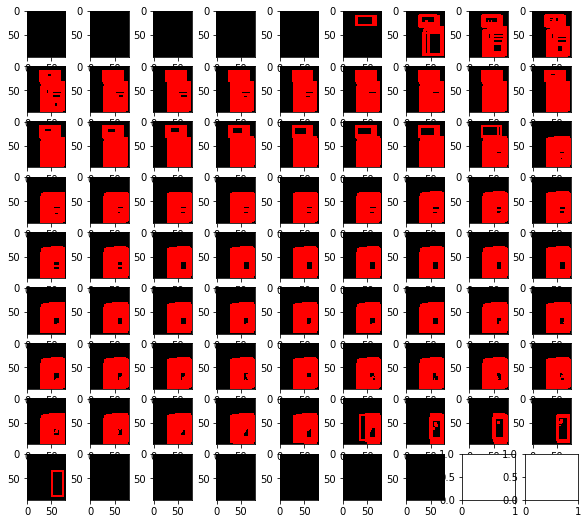

In [105]:
import matplotlib.patches as mpatches
ncols = 9
nrows = int(np.ceil(79/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 1*nrows))
flatten_axis = axes.flatten()

for ax, img in zip(flatten_axis, image[::1]):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)

for z0,y0,z1,y1,x0,x1 in bbox_coords:
    for z in range(z0,z1):
        flatten_axis[z].add_patch(mpatches.Rectangle((x0, y0), x1 - x0, y1 - y0,fill=False, edgecolor='red', linewidth=2))

In [109]:
# To check:
# Which slices is mostly used? No need to pick all slices if it is below a threshold of most common 

0     (11, 13, 16, 19, 37, 46)
1     (23, 33, 64, 88, 54, 74)
2      (9, 12, 19, 23, 33, 55)
3     (14, 34, 63, 89, 50, 74)
4     (15, 76, 19, 82, 41, 46)
5     (16, 79, 17, 80, 39, 41)
6     (19, 78, 20, 80, 45, 46)
7     (20, 79, 21, 80, 46, 47)
8     (21, 73, 22, 74, 51, 52)
9     (21, 77, 22, 78, 48, 49)
10    (16, 78, 18, 81, 58, 59)
11    (18, 37, 66, 89, 53, 74)
12    (18, 78, 21, 80, 55, 56)
13    (25, 85, 26, 86, 58, 59)
14    (14, 78, 15, 80, 40, 43)
15    (18, 34, 67, 89, 51, 75)
16    (23, 77, 24, 78, 54, 56)
17    (61, 76, 62, 77, 51, 52)
18    (65, 60, 66, 61, 62, 63)
19     (9, 17, 10, 18, 39, 40)
Name: bbox_list, dtype: object

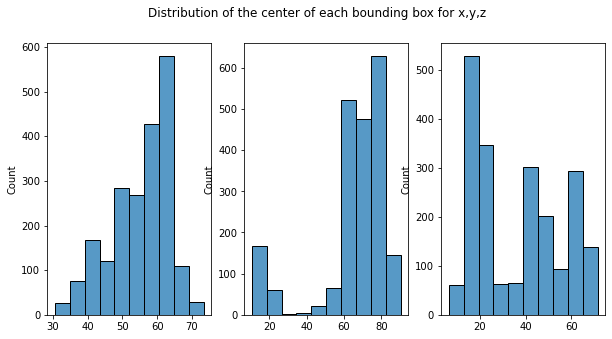

In [181]:
import seaborn as sns
def combine_coordinates(list_of_bbox):
    z = (list_of_bbox[0] + list_of_bbox[2])/2
    y = (list_of_bbox[1] + list_of_bbox[3])/2
    x = (list_of_bbox[4] + list_of_bbox[5])/2
    
    return x,y,z
bbox_listed = list(zip(*bbox_coords))

fig, axes = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle("Distribution of the center of each bounding box for x,y,z")
for ax,cord in zip(axes.flatten(),combine_coordinates(np.array(bbox_listed))):
    sns.histplot(cord, ax=ax,bins=10)

In [186]:
x,y,z = combine_coordinates(np.array(bbox_listed))

In [192]:
def max_occurance(occurances:list):
    u,c = np.unique(occurances, return_counts=True)
    max_val = u[c == c.max()]
    return max_val

In [197]:
max_occurance(x)

array([62.5])

In [ ]:
""" https://www.analyticsvidhya.com/blog/2020/08/selecting-the-right-bounding-box-using-non-max-suppression-with-implementation/
Step 1: Select the box with highest objectiveness score [Replace with intensity?] - Calculate with nms (package availible in segmentation)
Step 2: Then, compare the overlap (intersection over union) of this box with other boxes 
Step 3: Remove the bounding boxes with overlap (intersection over union) >50%
Step 4: Then, move to the next highest objectiveness score
Step 5: Finally, repeat steps 2-4
"""